RNA to RNA binary convolutional autoencoder
by Ivan Klimuk

In [2]:
# import some stuff

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Dropout, Lambda,  Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as B
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from random import sample
import os
os.chdir('D:\\Studies\\MicroarrayToRNAseq')

Using TensorFlow backend.


In [14]:
# custom metric (ratio of mistake distance to the length of the original vector)

def dist_error(y, y_pred):
    dist = B.sqrt(B.sum((y - y_pred)**2))
    y_length = B.sqrt(B.sum(y**2))
    return dist/y_length

In [9]:
# metric (the R2 coefficient of determination)

def R2_score(y_true, y_pred):
    SS_res =  B.sum(B.square( y_true-y_pred )) 
    SS_tot = B.sum(B.square( y_true - B.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + B.epsilon()) )

In [13]:
# function which converts the RNA data to binary mode width 20 digits per value (might be changed)

def RNA_binary(RNA, digits=20):
    binary = []
    for i in range(len(RNA)):
        binary.append([])
        for value in RNA[i]:
            bin_value = bin(int(round(value)))
            for k in range(digits-len(bin_value)+2):
                binary[i].append(0)
            for k in range(2, len(bin_value)):
                binary[i].append(int(bin_value[k]))
    return np.array(binary)     

In [15]:
# load our data

object_length = 32

RNA = np.loadtxt('./data/rnaseq.txt', skiprows=1, usecols=range(1,object_length+1))

print('RNA object:')
print(RNA[0])

RNA object:
[  479.  1062.   369.  4217.   689.   963.   595.  1144.   589.  1639.
  1347.   357.  1540.  1167.  5674.  3513.  6042.  4449.  3667.  9236.
  5262.  7235.  3220.  1166.  2175.  2295.  3130.   787.  3674.  3185.
  1168.  2321.]


In [16]:
# transform RNA data to binary 

RNA_bin = RNA_binary(RNA)
print('RNA binary object:')
print(RNA_bin[0])

RNA binary object:
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1
 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0
 0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0
 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1
 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1
 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0
 0 0 0

In [17]:
# reshape to image format m x n (m rows with n-dimensional binary vectors)
# 32 x 20 - works fine (weights saved)
# 20 x 32 - tests

m = 32
n = 20

In [18]:
RNA_img = np.reshape(RNA_bin, (len(RNA_bin),1,m,n))
print(RNA_img[0])

[[[0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1]
  [0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0]
  [0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1]
  [0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1]
  [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1]
  [0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1]
  [0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 1]
  [0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1]
  [0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1]
  [0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0]
  [0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1]
  [0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 1 0]
  [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 1]
  [0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1 0 1 0]
  [0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1]
  [0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0]
  [0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 1 0]
  [0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 1 1]
  [0 0 0 0 0 0 0 0 1 1 0 0 1 0 0

In [19]:
# convolutional autoencoder
# 2 Conv + MaxPooling layers, 2 Conv + UpSampling layers

input_RNA = Input(shape=(1,m,n))
print(B.int_shape(input_RNA))

layer1 = Conv2D(32, (4, 4), activation='relu', padding='same', data_format="channels_first")(input_RNA)
layer1_pooling = MaxPooling2D((2, 2), padding='same', data_format="channels_first")(layer1)
print(B.int_shape(layer1_pooling))

layer2 = Conv2D(16, (4, 4), activation='relu', padding='same', data_format="channels_first")(layer1_pooling)
encoded = MaxPooling2D((2, 2), padding='same', data_format="channels_first")(layer2)
print(B.int_shape(encoded))
print()

layer3 = Conv2D(16, (4, 4), activation='relu', padding='same', data_format="channels_first")(encoded)
layer3_sampling = UpSampling2D((2, 2), data_format="channels_first")(layer3)
print(B.int_shape(layer3_sampling))

layer4 = Conv2D(32, (4, 4), activation='relu', padding='same', data_format="channels_first")(layer3_sampling)
layer4_sampling = UpSampling2D((2, 2),data_format="channels_first")(layer4)
print(B.int_shape(layer4_sampling))

output_RNA = Conv2D(1, (4, 4), activation='sigmoid', padding='same', data_format="channels_first")(layer4_sampling)
print(B.int_shape(output_RNA))

RNA_to_RNA = Model(input_RNA, output_RNA)

RNA_to_RNA.compile(optimizer='adadelta',
                   loss='binary_crossentropy',
                   metrics=[R2_score]
                   )

(None, 1, 32, 20)
(None, 32, 16, 10)
(None, 16, 8, 5)

(None, 16, 16, 10)
(None, 32, 32, 20)
(None, 1, 32, 20)


In [26]:
# model training

training_history = RNA_to_RNA.fit(RNA_img, RNA_img,
                                  epochs=100,
                                  validation_split=0.2,
                                  verbose=2
                                 )

Train on 16026 samples, validate on 4007 samples
Epoch 1/100
226s - loss: 0.3067 - R2_score: 0.3239 - val_loss: 0.1840 - val_R2_score: 0.3998
Epoch 2/100
248s - loss: 0.2777 - R2_score: 0.3882 - val_loss: 0.1756 - val_R2_score: 0.4289
Epoch 3/100
262s - loss: 0.2687 - R2_score: 0.4105 - val_loss: 0.1723 - val_R2_score: 0.4398
Epoch 4/100
260s - loss: 0.2612 - R2_score: 0.4290 - val_loss: 0.1642 - val_R2_score: 0.4696
Epoch 5/100
200s - loss: 0.2556 - R2_score: 0.4427 - val_loss: 0.1613 - val_R2_score: 0.4795
Epoch 6/100
223s - loss: 0.2514 - R2_score: 0.4530 - val_loss: 0.1589 - val_R2_score: 0.4894
Epoch 7/100
209s - loss: 0.2476 - R2_score: 0.4623 - val_loss: 0.1551 - val_R2_score: 0.5016
Epoch 8/100
164s - loss: 0.2445 - R2_score: 0.4700 - val_loss: 0.1537 - val_R2_score: 0.5067
Epoch 9/100
188s - loss: 0.2413 - R2_score: 0.4778 - val_loss: 0.1526 - val_R2_score: 0.5113
Epoch 10/100
161s - loss: 0.2378 - R2_score: 0.4867 - val_loss: 0.1485 - val_R2_score: 0.5260
Epoch 11/100
160s - 

162s - loss: 0.1472 - R2_score: 0.7021 - val_loss: 0.0888 - val_R2_score: 0.7382
Epoch 89/100
161s - loss: 0.1467 - R2_score: 0.7031 - val_loss: 0.0869 - val_R2_score: 0.7445
Epoch 90/100
161s - loss: 0.1464 - R2_score: 0.7039 - val_loss: 0.0888 - val_R2_score: 0.7387
Epoch 91/100
160s - loss: 0.1462 - R2_score: 0.7043 - val_loss: 0.0886 - val_R2_score: 0.7391
Epoch 92/100
160s - loss: 0.1458 - R2_score: 0.7051 - val_loss: 0.0861 - val_R2_score: 0.7469
Epoch 93/100
162s - loss: 0.1454 - R2_score: 0.7061 - val_loss: 0.0882 - val_R2_score: 0.7403
Epoch 94/100
161s - loss: 0.1450 - R2_score: 0.7071 - val_loss: 0.0868 - val_R2_score: 0.7447
Epoch 95/100
161s - loss: 0.1448 - R2_score: 0.7075 - val_loss: 0.0860 - val_R2_score: 0.7477
Epoch 96/100
161s - loss: 0.1445 - R2_score: 0.7082 - val_loss: 0.0853 - val_R2_score: 0.7497
Epoch 97/100
160s - loss: 0.1440 - R2_score: 0.7092 - val_loss: 0.0875 - val_R2_score: 0.7425
Epoch 98/100
161s - loss: 0.1435 - R2_score: 0.7105 - val_loss: 0.0848 - 

In [27]:
# model training (50 more epochs) 

training_history2 = RNA_to_RNA.fit(RNA_img, RNA_img,
                                  epochs=50,
                                  validation_split=0.2,
                                  verbose=2
                                  )

Train on 16026 samples, validate on 4007 samples
Epoch 1/50
165s - loss: 0.1429 - R2_score: 0.7118 - val_loss: 0.0851 - val_R2_score: 0.7506
Epoch 2/50
168s - loss: 0.1423 - R2_score: 0.7130 - val_loss: 0.0848 - val_R2_score: 0.7516
Epoch 3/50
165s - loss: 0.1421 - R2_score: 0.7133 - val_loss: 0.0839 - val_R2_score: 0.7544
Epoch 4/50
165s - loss: 0.1418 - R2_score: 0.7142 - val_loss: 0.0852 - val_R2_score: 0.7505
Epoch 5/50
164s - loss: 0.1416 - R2_score: 0.7146 - val_loss: 0.0840 - val_R2_score: 0.7541
Epoch 6/50
167s - loss: 0.1412 - R2_score: 0.7155 - val_loss: 0.0828 - val_R2_score: 0.7582
Epoch 7/50
165s - loss: 0.1410 - R2_score: 0.7160 - val_loss: 0.0840 - val_R2_score: 0.7542
Epoch 8/50
161s - loss: 0.1408 - R2_score: 0.7166 - val_loss: 0.0828 - val_R2_score: 0.7582
Epoch 9/50
161s - loss: 0.1404 - R2_score: 0.7172 - val_loss: 0.0859 - val_R2_score: 0.7484
Epoch 10/50
161s - loss: 0.1400 - R2_score: 0.7181 - val_loss: 0.0853 - val_R2_score: 0.7502
Epoch 11/50
161s - loss: 0.139

In [28]:
# model training (100 more epochs) (takes REALLY long time)

training_history3 = RNA_to_RNA.fit(RNA_img, RNA_img,
                                  epochs=100,
                                  validation_split=0.2,
                                  verbose=2
                                  )

Train on 16026 samples, validate on 4007 samples
Epoch 1/100
170s - loss: 0.1297 - R2_score: 0.7413 - val_loss: 0.0765 - val_R2_score: 0.7787
Epoch 2/100
164s - loss: 0.1296 - R2_score: 0.7416 - val_loss: 0.0756 - val_R2_score: 0.7818
Epoch 3/100
195s - loss: 0.1292 - R2_score: 0.7424 - val_loss: 0.0757 - val_R2_score: 0.7816
Epoch 4/100
180s - loss: 0.1292 - R2_score: 0.7424 - val_loss: 0.0764 - val_R2_score: 0.7792
Epoch 5/100
185s - loss: 0.1290 - R2_score: 0.7428 - val_loss: 0.0757 - val_R2_score: 0.7815
Epoch 6/100
174s - loss: 0.1288 - R2_score: 0.7432 - val_loss: 0.0778 - val_R2_score: 0.7746
Epoch 7/100
175s - loss: 0.1285 - R2_score: 0.7441 - val_loss: 0.0752 - val_R2_score: 0.7832
Epoch 8/100
176s - loss: 0.1284 - R2_score: 0.7440 - val_loss: 0.0771 - val_R2_score: 0.7769
Epoch 9/100
176s - loss: 0.1280 - R2_score: 0.7449 - val_loss: 0.0760 - val_R2_score: 0.7810
Epoch 10/100
171s - loss: 0.1281 - R2_score: 0.7448 - val_loss: 0.0742 - val_R2_score: 0.7864
Epoch 11/100
167s - 

168s - loss: 0.1191 - R2_score: 0.7643 - val_loss: 0.0696 - val_R2_score: 0.8008
Epoch 89/100
167s - loss: 0.1189 - R2_score: 0.7646 - val_loss: 0.0756 - val_R2_score: 0.7822
Epoch 90/100
169s - loss: 0.1188 - R2_score: 0.7650 - val_loss: 0.0693 - val_R2_score: 0.8016
Epoch 91/100
167s - loss: 0.1188 - R2_score: 0.7649 - val_loss: 0.0695 - val_R2_score: 0.8010
Epoch 92/100
169s - loss: 0.1188 - R2_score: 0.7649 - val_loss: 0.0704 - val_R2_score: 0.7981
Epoch 93/100
166s - loss: 0.1186 - R2_score: 0.7652 - val_loss: 0.0685 - val_R2_score: 0.8045
Epoch 94/100
166s - loss: 0.1186 - R2_score: 0.7653 - val_loss: 0.0732 - val_R2_score: 0.7896
Epoch 95/100
170s - loss: 0.1185 - R2_score: 0.7654 - val_loss: 0.0697 - val_R2_score: 0.8004
Epoch 96/100
166s - loss: 0.1185 - R2_score: 0.7655 - val_loss: 0.0684 - val_R2_score: 0.8047
Epoch 97/100
165s - loss: 0.1182 - R2_score: 0.7661 - val_loss: 0.0717 - val_R2_score: 0.7939
Epoch 98/100
169s - loss: 0.1185 - R2_score: 0.7654 - val_loss: 0.0709 - 

In [30]:
# model training (100 more epochs) (takes REALLY long time)

training_history3 = RNA_to_RNA.fit(RNA_img, RNA_img,
                                  epochs=100,
                                  validation_split=0.2,
                                  verbose=2
                                  )

Train on 16026 samples, validate on 4007 samples
Epoch 1/100
161s - loss: 0.1128 - R2_score: 0.7776 - val_loss: 0.0655 - val_R2_score: 0.8138
Epoch 2/100
162s - loss: 0.1128 - R2_score: 0.7778 - val_loss: 0.0649 - val_R2_score: 0.8155
Epoch 3/100
161s - loss: 0.1126 - R2_score: 0.7781 - val_loss: 0.0668 - val_R2_score: 0.8099
Epoch 4/100
192s - loss: 0.1125 - R2_score: 0.7784 - val_loss: 0.0660 - val_R2_score: 0.8122
Epoch 5/100
162s - loss: 0.1126 - R2_score: 0.7782 - val_loss: 0.0649 - val_R2_score: 0.8158
Epoch 6/100
214s - loss: 0.1126 - R2_score: 0.7780 - val_loss: 0.0681 - val_R2_score: 0.8057
Epoch 7/100
292s - loss: 0.1124 - R2_score: 0.7786 - val_loss: 0.0691 - val_R2_score: 0.8030
Epoch 8/100
187s - loss: 0.1124 - R2_score: 0.7785 - val_loss: 0.0684 - val_R2_score: 0.8047
Epoch 9/100
189s - loss: 0.1126 - R2_score: 0.7781 - val_loss: 0.0657 - val_R2_score: 0.8130
Epoch 10/100
198s - loss: 0.1125 - R2_score: 0.7783 - val_loss: 0.0698 - val_R2_score: 0.8010
Epoch 11/100
201s - 

161s - loss: 0.1093 - R2_score: 0.7853 - val_loss: 0.0634 - val_R2_score: 0.8206
Epoch 89/100
199s - loss: 0.1095 - R2_score: 0.7848 - val_loss: 0.0642 - val_R2_score: 0.8181
Epoch 90/100
163s - loss: 0.1097 - R2_score: 0.7843 - val_loss: 0.0638 - val_R2_score: 0.8196
Epoch 91/100
194s - loss: 0.1094 - R2_score: 0.7848 - val_loss: 0.0627 - val_R2_score: 0.8231
Epoch 92/100
161s - loss: 0.1095 - R2_score: 0.7848 - val_loss: 0.0651 - val_R2_score: 0.8155
Epoch 93/100
191s - loss: 0.1094 - R2_score: 0.7851 - val_loss: 0.0637 - val_R2_score: 0.8198
Epoch 94/100
160s - loss: 0.1093 - R2_score: 0.7852 - val_loss: 0.0658 - val_R2_score: 0.8133
Epoch 95/100
191s - loss: 0.1092 - R2_score: 0.7853 - val_loss: 0.0644 - val_R2_score: 0.8177
Epoch 96/100
160s - loss: 0.1092 - R2_score: 0.7853 - val_loss: 0.0639 - val_R2_score: 0.8193
Epoch 97/100
193s - loss: 0.1093 - R2_score: 0.7852 - val_loss: 0.0636 - val_R2_score: 0.8199
Epoch 98/100
160s - loss: 0.1095 - R2_score: 0.7848 - val_loss: 0.0655 - 

In [8]:
# save weights of our model

if m == 32:
    RNA_weights_name = './models/rna_to_rna_binary_classic.h5'
elif m == 20:
    RNA_weights_name = './models/rna_to_rna_binary_alternative_image.h5'

In [11]:
RNA_to_RNA.save_weights(RNA_weights_name)

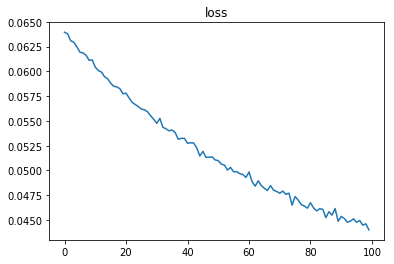

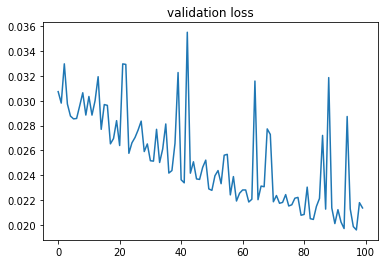

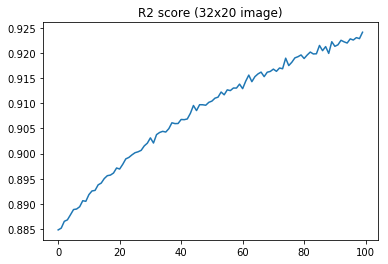

In [38]:
# have a look at the loss, validation loss and mistake

plt.plot(training_history.history['loss'])
plt.title('loss')
plt.show()
plt.plot(training_history.history['val_loss'])
plt.title('validation loss')
plt.show()
plt.plot(training_history.history['R2_score'])
plt.title('R2 score (32x20 image)')
plt.show()

In [20]:
# load weights (only if necessary!)

RNA_to_RNA.load_weights(RNA_weights_name)


Object no. 19657


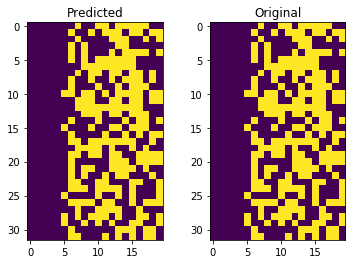

False pixels: 12.0 from 640


In [24]:
n = 19657
print('\nObject no.', n)

plt.subplot(1,2,1)
plt.imshow(RNA_img[n].reshape(32,20))
plt.title('Predicted')
plt.subplot(1,2,2)
plt.imshow(RNA_img[n].reshape(32,20))
plt.title('Original')
plt.show()

print("False pixels: 12.0 from 640")


Object no. 3919
[ 1075.   950.   619.   611.   599.   984.   678.   746.   847.   807.
  1236.   579.   698.   573.   531.  1003.   618.  1070.  1024.   961.
   546.   723.   805.  1764.  2448.  1428.   802.   834.  1789.  1108.
  2115.  2818.]
[[[0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1]
  [0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 1 1 0]
  [0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1]
  [0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1]
  [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 1]
  [0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0]
  [0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1 0]
  [0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 1]
  [0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 1]
  [0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1]
  [0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 0]
  [0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1]
  [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1]
  [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1 1]
  [0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0]
  [0 0

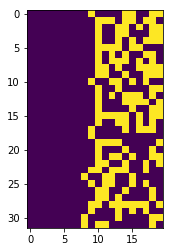

In [12]:
n = sample(range(1,len(RNA) + 1), 1)[0]
print('\nObject no.', n)

print(RNA[n])
print(RNA_img[n])
plt.imshow(RNA_img[n].reshape(32,20))
plt.show()


Object no. 19155


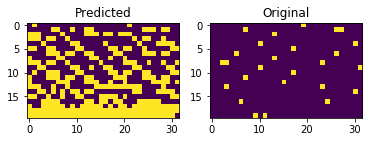

False pixels:  283.0 from 640

Object no. 11824


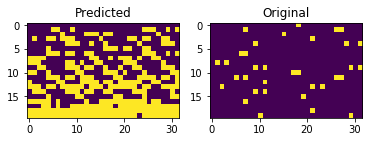

False pixels:  290.0 from 640

Object no. 4319


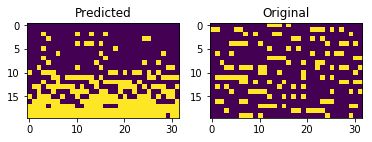

False pixels:  277.0 from 640

Object no. 18501


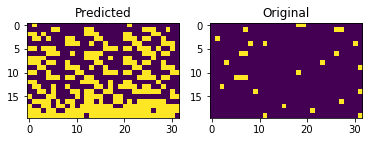

False pixels:  286.0 from 640

Object no. 4061


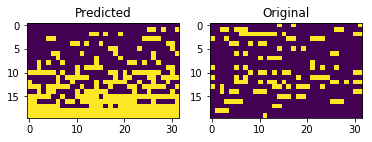

False pixels:  306.0 from 640

Object no. 3318


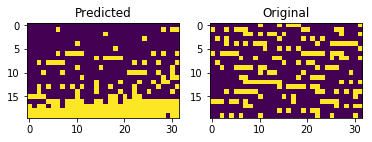

False pixels:  273.0 from 640

Object no. 127


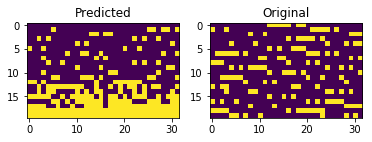

False pixels:  269.0 from 640

Object no. 6325


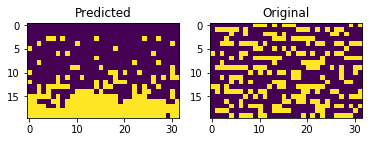

False pixels:  276.0 from 640

Object no. 10305


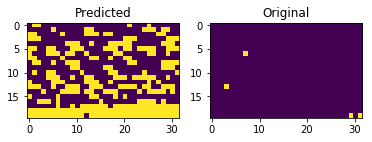

False pixels:  270.0 from 640

Object no. 13193


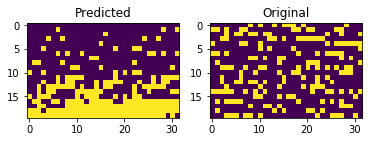

False pixels:  285.0 from 640


In [25]:
# have a look at predicted and original image

for i in range(10):
    n = sample(range(1,len(RNA) + 1), 1)[0]
    print('\nObject no.', n)

    RNA_img_test = np.round(RNA_to_RNA.predict(np.array([RNA_img[n]])))

    plt.subplot(1,2,1)
    plt.imshow(RNA_img_test.reshape(20,32))
    plt.title('Predicted')
    plt.subplot(1,2,2)
    plt.imshow(RNA_img[n].reshape(20,32))
    plt.title('Original')
    plt.show()

    print("False pixels: ", np.sum(np.absolute(RNA_img_test.reshape(32,20) - RNA_img[n].reshape(32,20))), "from 640")